In [88]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb


In [89]:
# Load data
df = pd.read_csv('data/food_delivery.csv')

In [90]:
df.drop('ID',axis=1,inplace=True)

In [91]:
# Handling missing values 
# Data Preprocessing
# Feature Engineering

df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].str.strip()
mode_ratings = df['Delivery_person_Ratings'].mode()[0]
df['Delivery_person_Ratings'] = pd.to_numeric(df['Delivery_person_Ratings'], errors='coerce')
df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].fillna(mode_ratings)
df['Delivery_person_Ratings'] =  df['Delivery_person_Ratings'].replace('6',mode_ratings)
df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].astype('float64')


In [92]:
df['Delivery_person_Age'] = df['Delivery_person_Age'].replace('NaN', np.nan)
df['Delivery_person_Age'] = df['Delivery_person_Age'].astype('float64')
df['Delivery_person_Age'] = df['Delivery_person_Age'].fillna(df['Delivery_person_Age'].mean())
df['Delivery_person_Age'] = df['Delivery_person_Age'].astype(int)

In [93]:

df['City'] = df['City'].replace(r'^\s*$', np.nan, regex=True)
df['City'] = df['City'].replace('', np.nan)
city_mode = df['City'].mode()[0]
df['City'] = df['City'].fillna(city_mode)
df['City'] = df['City'].replace('NaN ','Metropolitian ')

In [94]:
mode_multiple_deliveries = df['multiple_deliveries'].mode()[0]
df['multiple_deliveries'] = df['multiple_deliveries'].replace('NaN ',mode_multiple_deliveries)
df['multiple_deliveries'] = df['multiple_deliveries'].astype('int64')

In [95]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'], format='%d-%m-%Y')
df['Order_day'] = df['Order_Date'].dt.day.astype('int64')
df['Order_month'] = df['Order_Date'].dt.month.astype('int64')
df['Order_year'] = df['Order_Date'].dt.year.astype('int64')

In [96]:
df['Time_Orderd']=df['Time_Orderd'].fillna(df.Time_Orderd.mode()[0])
df['Time_Orderd'] = pd.to_datetime(df['Time_Orderd'], format='%H:%M:%S', errors='coerce').dt.time
df['Time_Order_picked'] = pd.to_datetime(df['Time_Order_picked'], format='%H:%M:%S', errors='coerce').dt.time
df['Time_taken(min)'] = df['Time_taken(min)'].str.extract(r'(\d+)').astype('Int64')

In [97]:
#df['Order_Time'] = df['Time_Orderd'].dt.time
#df['Pick_Time'] = df['Time_Order_picked'].dt.time


In [98]:

df['Weatherconditions']=df['Weatherconditions'].fillna(df['Weatherconditions'].mode()[0])
df['Weatherconditions'] = df['Weatherconditions'].str.replace('conditions ', '')
df = df.rename(columns={'Weatherconditions': 'Weather_Conditions'})

In [99]:
festival_mode = df['Festival'].mode()
df['Festival'] = df['Festival'].fillna(festival_mode)
df['Festival'] = df['Festival'].replace('NaN ', 'No ')

In [100]:
df['Road_traffic_density']=df['Road_traffic_density'].fillna(df.Road_traffic_density.mode()[0])
df['Road_traffic_density'] = df['Road_traffic_density'].str.replace('NaN ' , df['Road_traffic_density'].mode()[0])

In [101]:
def calculate_distance(row):
    start = (row['Restaurant_latitude'], row['Restaurant_longitude'])
    end = (row['Delivery_location_latitude'], row['Delivery_location_longitude'])
    return geodesic(start, end).kilometers

df['distance'] =df.apply(calculate_distance, axis=1)

In [102]:
df['Repeat_Customer'] = df['Delivery_person_ID'].duplicated(keep=False).astype(int)

In [103]:
df['Delivery_Speed'] = df['distance'] / df['Time_taken(min)']

In [104]:
weather_severity_map = {
    'Sunny': 'Mild',
    'Windy': 'Moderate',
    'Cloudy': 'Moderate',
    'Fog': 'Severe',
    'Stormy': 'Severe',
    'Sandstorms': 'Severe'
}
df['Weather_Severity'] = df['Weather_Conditions'].map(weather_severity_map)


In [105]:
df['Traffic_Impact'] = df['Road_traffic_density'].apply(lambda x: 1 if x in ['Jam', 'High'] else 0)

In [106]:
# Setting X, y variables
X= df.drop('Time_taken(min)', axis=1)
y =df['Time_taken(min)']

In [107]:
y.head()

0    24
1    33
2    26
3    21
4    30
Name: Time_taken(min), dtype: Int64

In [108]:
# Define categorical and numerical columns
categorical_cols = [
    'Weather_Conditions',
    'Road_traffic_density',
    'Type_of_order',
    'Type_of_vehicle',
    'Festival',
    'City'
]

numerical_cols = [
    'Delivery_person_Age',
    'Delivery_person_Ratings',
    'Vehicle_condition',
    'distance',
    'Order_day',
    'Order_month',
    'Order_year',
    'multiple_deliveries'
]

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['Delivery_person_Age', 'Delivery_person_Ratings', 'Vehicle_condition', 'distance', 'Order_day', 'Order_month', 'Order_year', 'multiple_deliveries']
Categorical Columns: ['Weather_Conditions', 'Road_traffic_density', 'Type_of_order', 'Type_of_vehicle', 'Festival', 'City']


In [109]:
numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

In [110]:
X = preprocessor.fit_transform(X)

In [111]:
X.shape

(45593, 26)

In [112]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size =0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((36474, 26), (9119, 26), (36474,), (9119,))

In [113]:
# Model Evaluation
def evaluate_model(true, predicted):
    # Calculate MAE, MSE, RMSE, and R2 score fro model evaluation
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2 = r2_score(true, predicted)
    return mae, mse, rmse, r2

In [119]:
# Model definition and training
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor(),
    "LightGBM": LGBMRegressor()
}

model_list= []
r2_list=[]
mae_list=[]
mse_list=[]
rmse_list=[]


for name, model in models.items():
    #train the each model
    model.fit(X_train, y_train)

    #Make predictions
    y_pred = model.predict(X_train)
    y_test_pred =model.predict(X_test)

    #Evaluate train and test datasets
    model_train_mae, model_train_mse, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_pred)
    model_test_mae, model_test_mse, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(name)
    model_list.append(name)
    
    #print the performance of the model
    print('Model Training Performance')
    print("MAE: {:.4f}".format(model_train_mae))
    print("MSE: {:.4f}".format(model_train_mse))
    print("RMSE: {:.4f}".format(model_train_rmse))
    print("R2 Score: {:.4f}".format(model_train_r2))

    print('--------------------------------')
    print('Model Testing Performance')
    print("MAE: {:.4f}".format(model_test_mae))
    print("MSE: {:.4f}".format(model_test_mse))
    print("RMSE: {:.4f}".format(model_test_rmse))
    print("R2 Score: {:.4f}".format(model_test_r2))

    print('--------------------------------')
    print('--------------------------------')

    r2_list.append(model_train_r2)
    mae_list.append(model_train_mae)
    mse_list.append(model_train_mse)
    rmse_list.append(model_train_rmse)

    
    

Linear Regression
Model Training Performance
MAE: 4.9757
MSE: 39.4651
RMSE: 6.2821
R2 Score: 0.5523
--------------------------------
Model Testing Performance
MAE: 4.9325
MSE: 38.9199
RMSE: 6.2386
R2 Score: 0.5561
--------------------------------
--------------------------------
Random Forest
Model Training Performance
MAE: 1.1894
MSE: 2.3408
RMSE: 1.5300
R2 Score: 0.9734
--------------------------------
Model Testing Performance
MAE: 3.2397
MSE: 16.7737
RMSE: 4.0956
R2 Score: 0.8087
--------------------------------
--------------------------------
Gradient Boosting
Model Training Performance
MAE: 3.6969
MSE: 21.6947
RMSE: 4.6578
R2 Score: 0.7539
--------------------------------
Model Testing Performance
MAE: 3.7065
MSE: 21.7067
RMSE: 4.6590
R2 Score: 0.7524
--------------------------------
--------------------------------
XGBoost
Model Training Performance
MAE: 2.7943
MSE: 12.4396
RMSE: 3.5270
R2 Score: 0.8589
--------------------------------
Model Testing Performance
MAE: 3.2416
MSE:

/Users/cerenakgun/Desktop/customer_delivery_predictor/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/cerenakgun/Desktop/customer_delivery_predictor/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [120]:
pd.DataFrame(list(zip(model_list, r2_list, mae_list, mse_list, rmse_list)), columns=['Model Name', 'R2_Score', 'MAE', 'MSE', 'RMSE']).sort_values(by=["R2_Score"],ascending=False)


,Model Name,R2_Score,MAE,MSE,RMSE
1,Random Forest,0.973445,1.189403,2.340756,1.529953
3,XGBoost,0.858878,2.794295,12.439588,3.526980
4,LightGBM,0.831508,3.077714,14.852180,3.853853
2,Gradient Boosting,0.753883,3.696873,21.694653,4.657752
0,Linear Regression,0.552284,4.975682,39.465103,6.282126


## Insights
The Random Forest model demonstrates best performance with the highest R² score (0.973) and lowest error metrics (MAE: 1.18, RMSE: 1.52), suggesting it captures the data patterns very well. XGBoost and LightGBM follow with strong performances (R²: 0.858 and 0.831 respectively), showing good generalization capabilities. Gradient Boosting shows moderate performance (R²: 0.753), while Linear Regression performs the weakest (R²: 0.552), indicating non-linear relationships in the data. The ensemble methods (Random Forest, XGBoost, LightGBM) significantly outperform the linear model, suggesting complex feature interactions in the delivery time prediction task.

In [123]:
random_forest_model= models["Random Forest"]
random_forest_model.fit(X_train, y_train)
y_pred = random_forest_model.predict(X_test)
score = random_forest_model.score(X_test, y_test) * 100
print(f"Random Forest Model Accuracy: {score:.2f}%")



Random Forest Model Accuracy: 80.87%


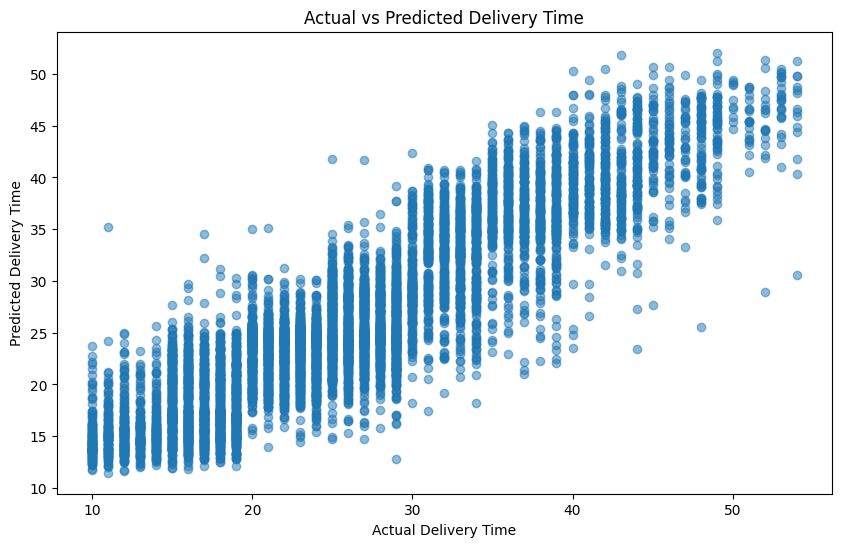

In [128]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual Delivery Time')
plt.ylabel('Predicted Delivery Time')
plt.title('Actual vs Predicted Delivery Time')
plt.show()


- The R² score of 0.81 (81% accuracy) is reflected in how closely the points follow this pattern
- Actual delivery times range from about 10 to 54 minutes
- Predicted times fall within a similar range
- Mostpredictions cluster between 15-45 minutes
- The spread of points around the ideal diagonal line shows the prediction errors
- Predictions are more accurate for shorter delivery times (10-30 minutes) as s shown by tighter clustering

In [125]:

pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
7725,44,42.50,1.5
949,41,44.48,-3.48
44893,39,35.61,3.39
42071,38,41.59,-3.59
27091,38,44.10,-6.1
...,...,...,...
7388,15,25.39,-10.39
6330,34,30.31,3.69
8426,21,21.95,-0.95
768,17,27.87,-10.87


In [122]:
# Model Save
import joblib
from pathlib import Path

# Create models directory if it doesn't exist
Path("models").mkdir(exist_ok=True)

# Save the best model (Random Forest)
best_model = models["Random Forest"]
joblib.dump(best_model, 'models/random_forest_model.joblib')

# Save the preprocessor
joblib.dump(preprocessor, 'models/preprocessor.joblib')

print("Model and preprocessor saved successfully!")

Model and preprocessor saved successfully!
